# Revenue Modeling: Soda

**Purpose:** This notebook models soda tax revenue using a re-scaled baseline forecast to model the impact of COVID-19 and subsequent recovery. The methodology relies on the Prophet package and is similar to the analysis used in [this previous report](https://controller.phila.gov/philadelphia-audits/covid19-fiscal-impact-mar-2021/).


In [1]:
# Base imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from phila_style.matplotlib import get_theme
from phila_style import *

# Prophet
from fbprophet import Prophet

# fyp-analsis
from fyp_analysis.pipelines.modeling.predict import (
    aggregate_to_fiscal_year,
    plot_projection_comparison,
)
from fyp_analysis import SRC_DIR

2022-07-11 16:05:52,549 - fbprophet.plot - ERROR - Importing plotly failed. Interactive plots will not work.


/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
pd.options.display.max_columns = 999

## Setup

In [3]:
PARAMS = context.params

In [36]:
# First fiscal year of the plan
plan_start_year = PARAMS["plan_start_year"]

## Load the monthly data

This is monthly data pulled from the monthly Revenue Department reports.

In [5]:
city_tax_collections = pd.read_csv(
    "https://raw.githubusercontent.com/PhilaController/phl-budget-data/main/src/phl_budget_data/data/processed/collections/city-tax-collections.csv"
)

In [6]:
soda_tax = (
    city_tax_collections.query("name == 'soda' and kind=='total'")
    .assign(date=lambda df: pd.to_datetime(df.date))
    .query("total > 0")
    .set_index("date")
)

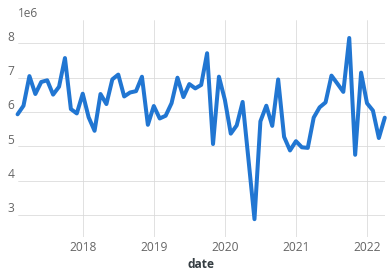

In [7]:
with plt.style.context(get_theme()):
    soda_tax.plot(y="total", legend=False, clip_on=False)

## Modeling

In [8]:
df = (
    pd.concat([soda_tax[:"2020-04"], soda_tax["2021-04":]])
    .rename_axis("ds")
    .reset_index()
    .rename(columns={"total": "y"})
    .sort_values("ds")
)

In [9]:
def covid_regressor(dt):
    if dt.year == 2020:
        if dt.month == 5:
            return -0.5
        elif dt.month == 6:
            return -1
        elif dt.month > 6:
            return -0.25
    elif dt.year >= 2021:
        return 0.5

    return 0.0

In [10]:
#df['covid'] = df['ds'].apply(covid_regressor)

In [11]:
fit_kwargs = {
    "daily_seasonality": False,
    "weekly_seasonality": False,
   # "seasonality_mode": "multiplicative"
}

In [12]:
model = Prophet(changepoints=['2021-04-01'], **fit_kwargs)
#model.add_regressor("covid")
model.fit(df);

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/pyximport/pyximport.py:51: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp



Initial log joint probability = -117.473


/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    30.6833. Improved by 148.157.
Iteration  2. Log joint probability =    99.6392. Improved by 68.9559.
Iteration  3. Log joint probability =    125.201. Improved by 25.5615.
Iteration  4. Log joint probability =    131.054. Improved by 5.85276.
Iteration  5. Log joint probability =    131.071. Improved by 0.0177886.
Iteration  6. Log joint probability =    131.076. Improved by 0.0049044.
Iteration  7. Log joint probability =    131.077. Improved by 0.000978267.
Iteration  8. Log joint probability =     131.08. Improved by 0.00279149.
Iteration  9. Log joint probability =     131.08. Improved by 7.30853e-05.
Iteration 10. Log joint probability =    131.082. Improved by 0.00181002.
Iteration 11. Log joint probability =    131.083. Improved by 0.00146792.
Iteration 12. Log joint probability =    131.083. Improved by 2.42358e-05.
Iteration 13. Log joint probability =    131.083. Improved by 5.16779e-06.
Iteration 14. Log joint probability =    131.083

In [13]:
future = model.make_future_dataframe(periods=12 * 5 + 2, freq="MS")
#future['covid'] = future['ds'].apply(covid_regressor)

In [14]:
future.tail()

,ds
109,2027-02-01
110,2027-03-01
111,2027-04-01
112,2027-05-01
113,2027-06-01


In [15]:
forecast = model.predict(future)

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: Depreca

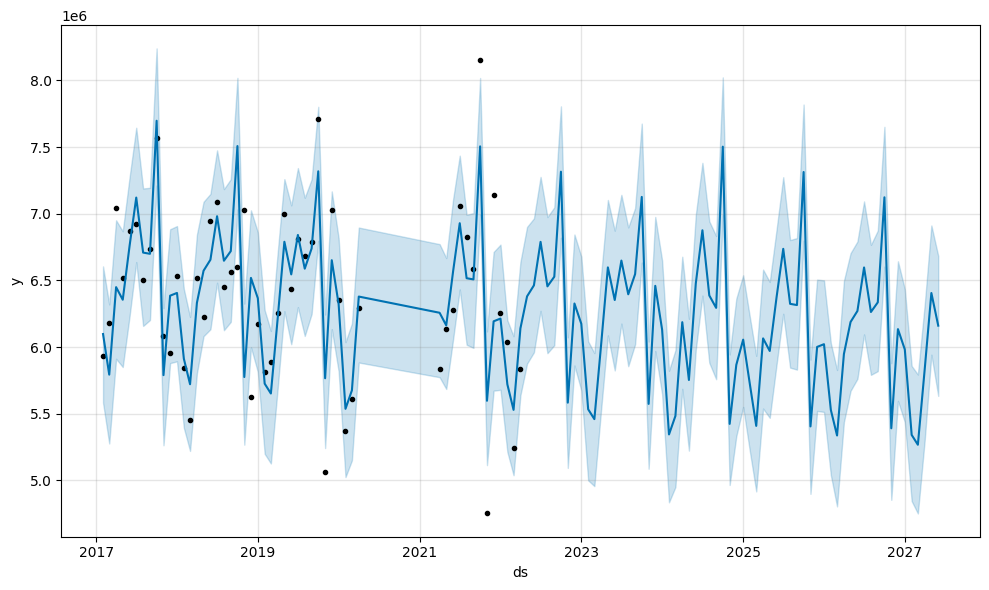

In [16]:
model.plot(forecast);

In [17]:
FORECAST = aggregate_to_fiscal_year(
    forecast.set_index("ds")["yhat"], freq="MS"
).squeeze()

In [18]:
FORECAST/1e6

fiscal_year
2017    31.457309
2018    78.005116
2019    77.452624
2020    63.820213
2021    18.989135
2022    75.698453
2023    75.145960
2024    74.127969
2025    73.943281
2026    73.391790
2027    72.839297
Name: yhat, dtype: float64

In [19]:
growth_rates = 100 * (FORECAST.diff() / FORECAST.shift())

growth_rates

fiscal_year
2017           NaN
2018    147.971359
2019     -0.708277
2020    -17.600967
2021    -70.245892
2022    298.640869
2023     -0.729860
2024     -1.354686
2025     -0.249147
2026     -0.745831
2027     -0.752799
Name: yhat, dtype: float64

## Compare to Five Year Plan and save

Five Year Plan numbers from Adopted FY22-FY26 Plan:

In [20]:
FYP = pd.Series(
    [77894000, 78813000, 78025000, 77604000, 77270000],
    index=pd.Index(range(plan_start_year, plan_start_year + 5), name="fiscal_year"),
)

In [21]:
FYP

fiscal_year
2023    77894000
2024    78813000
2025    78025000
2026    77604000
2027    77270000
dtype: int64

In [22]:
def get_final_dataframe(forecast, budget):
    final = pd.concat(
        [forecast.rename("Controller"), budget.rename("Five Year Plan")], axis=1
    )

    final.loc[2022, :] = 76932000
    final["Five Year Plan"] = final["Five Year Plan"].fillna(final["Controller"])

    return final

In [23]:
final = get_final_dataframe(FORECAST, FYP)

In [24]:
final.head()

,Controller,Five Year Plan
fiscal_year,,
2017,3.145731e+07,3.145731e+07
2018,7.800512e+07,7.800512e+07
2019,7.745262e+07,7.745262e+07
2020,6.382021e+07,6.382021e+07
2021,1.898914e+07,1.898914e+07


In [25]:
final.tail()

,Controller,Five Year Plan
fiscal_year,,
2023,7.514596e+07,77894000.0
2024,7.412797e+07,78813000.0
2025,7.394328e+07,78025000.0
2026,7.339179e+07,77604000.0
2027,7.283930e+07,77270000.0


Save the result:

In [26]:
final.to_excel(SRC_DIR / ".." / ".." / "data" / "06_model_output" / "soda-forecast.xlsx")

Plot:

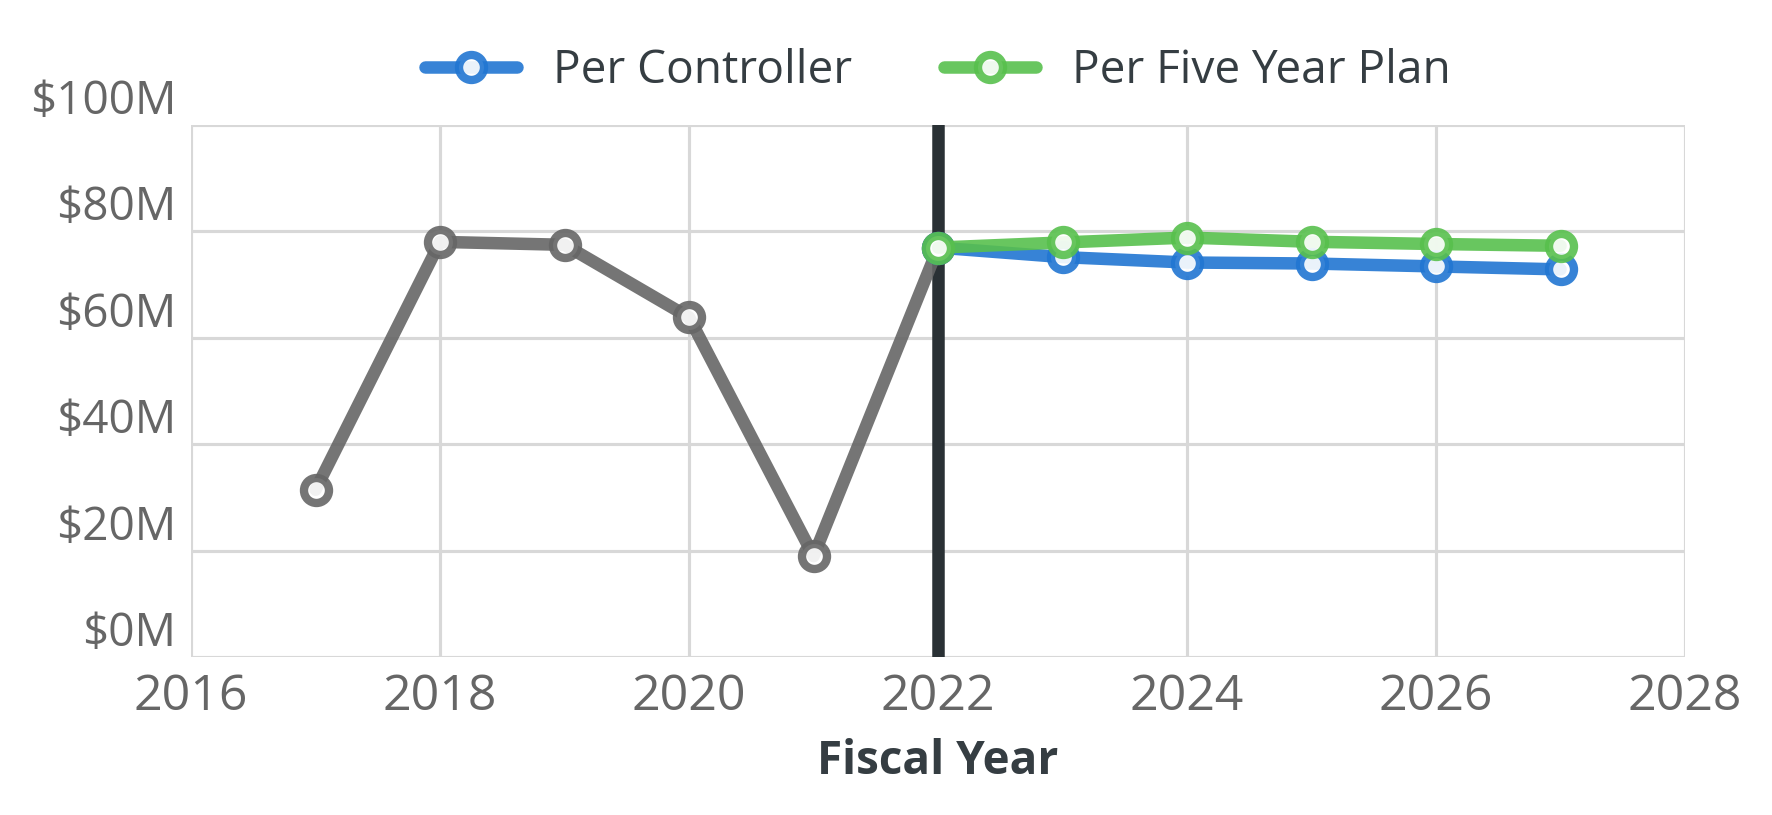

In [37]:
comparison = final.copy()

# Put into millions
for col in comparison:
    comparison[col] /= 1e6

# Columns
col = "Controller"
start_year = 2017

# Plot
with plt.style.context(get_theme()):

    fig, ax = plt.subplots(
        figsize=(6, 2.5), gridspec_kw=dict(bottom=0.17, left=0.12, top=0.88, right=0.95)
    )

    colors = get_default_palette()
    kws = dict(
        lw=3,
        mew=2,
        alpha=0.9,
    )

    # Plot vertical line
    this_year = plan_start_year - 1
    ax.axvline(x=this_year, c=colors["dark-gray"], lw=3)

    # Plot historic
    color = colors["medium-gray"]
    comparison[col].loc[start_year:this_year].plot(
        ax=ax,
        marker="o",
        color=color,
        mec=color,
        mfc="white",
        label="",
        clip_on=False,
        **kws,
    )

    F = comparison.loc[this_year:].copy()

    # Plot Controller
    color = colors["blue"]
    F["Controller"].plot(
        ax=ax,
        marker="o",
        color=color,
        mec=color,
        mfc="white",
        label="Per Controller",
        clip_on=False,
        **kws,
    )

    # Plot Mayor
    color = colors["green"]
    F["Five Year Plan"].plot(
        ax=ax,
        marker="o",
        color=color,
        mec=color,
        mfc="white",
        label="Per Five Year Plan",
        clip_on=False,
        **kws,
    )

    ax.set_xlabel("Fiscal Year", fontsize=11)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([f"${x:,.0f}M" for x in ax.get_yticks()], fontsize=11)

    ax.set_xlim(start_year, plan_start_year + 5)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([f"{x:.0f}" for x in ax.get_xticks()])

    ax.legend(
        loc="lower center",
        bbox_transform=ax.transAxes,
        bbox_to_anchor=(0.5, 0.98),
        ncol=2,
        fontsize=11,
    )

    plt.savefig(
        SRC_DIR
        / ".."
        / ".."
        / "data"
        / "06_model_output"
        / "forecast_figures"
        / "Soda.png"
    )

## Old Analysis

Make the future forecast through the end of the Plan:

In [28]:
# Get the forecast period
freq = "M"
forecast_stop_date = "2027-06-30"
periods = (
    pd.to_datetime(forecast_stop_date).to_period(freq) - df["ds"].max().to_period(freq)
).n
future = model.make_future_dataframe(periods=periods + 24, freq=f"{freq}S")

In [29]:
future.tail()

,ds
133,2029-02-01
134,2029-03-01
135,2029-04-01
136,2029-05-01
137,2029-06-01


Run the forecast:

In [30]:
# Forecast
forecast = model.predict(future)

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: Depreca

Calculate fiscal year growth rates:

In [31]:
fy_forecast = aggregate_to_fiscal_year(forecast.set_index("ds")["yhat"], freq="MS")

In [32]:
growth_rates = 100 * (fy_forecast.diff() / fy_forecast.shift())

growth_rates

,yhat
fiscal_year,
2017,NaN
2018,147.971359
2019,-0.708277
2020,-17.600967
2021,-70.245892
2022,298.640869
2023,-0.729860
2024,-1.354686
2025,-0.249147


## Generate a "no-growth" baseline

Repeat the pre-COVID data for each year in the forecast period

In [33]:
def project_flat_growth(X, start="2019-04", stop="2020-03"):
    """Normalize future growth to be flat at the last annual period."""
    # Make a copy first
    X = X.copy()
    freq = X.index.inferred_freq
    X.index.freq = freq

    # This is the part that will be projected
    norm = X.loc[start:stop].copy()
    latest_date = norm.index[-1]

    # This should be monthly or quarterly
    assert len(norm) in [4, 12]
    if len(norm) == 4:
        key = lambda dt: dt.quarter
    else:
        key = lambda dt: dt.month

    # Reset the index to months/quarters
    norm.index = [key(dt) for dt in norm.index]

    # Change the forecast to be flat
    forecast_start = latest_date + latest_date.freq
    Y = X.loc[forecast_start:].copy()

    # Reset index
    i = Y.index
    Y.index = [key(dt) for dt in Y.index]

    # Overwrite
    Y.loc[:] = norm.loc[Y.index].values
    Y.index = i

    # Add back to original
    X.loc[Y.index] = Y.values

    return X

In [34]:
forecast = (
    forecast[
        [
            "ds",
            "yhat",
            "yhat_lower",
            "yhat_upper",
            "yearly",
            "trend",
        ]
    ]
    .rename(
        columns={
            "ds": "date",
            "yhat": "total",
            "yhat_lower": "lower",
            "yhat_upper": "upper",
        }
    )
    .set_index("date")
)

In [35]:
flat_forecast = project_flat_growth(forecast)

/var/folders/n4/d05s5jdd7pn_v955k5trnt5h0000gn/T/ipykernel_59952/411335502.py:23: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  forecast_start = latest_date + latest_date.freq


TypeError: unsupported operand type(s) for +: 'Timestamp' and 'NoneType'

## Examine recovery so far

Use the actual data to see how collections have responded since COVID

In [ ]:
ratios = (soda_tax["total"] / flat_forecast["total"]).dropna()

In [ ]:
ratios.loc["2020":]

## Set up future recovery

**Assumptions**

- A two-year recovery period
- After this period, growth rates is assumed to be -1%
- Permanent loss of 1% to the overall base

Set up the monthly dates for the two different forecast periods:

In [ ]:
future_dates_1 = pd.date_range("2021-07-01", "2023-06-30", freq="MS")
future_dates_2 = pd.date_range("2023-07-01", "2027-06-30", freq="MS")

In [ ]:
LIMIT = 0.99

In [ ]:
future_ratios_1 = pd.Series(
    [0.9] * 3 + [0.925] * 3 + [0.95] * 6 + [0.97] * 6 + [LIMIT] * 6,
    index=future_dates_1,
)
future_ratios_2 = pd.Series(
    [LIMIT * 0.99] * 12
    + [LIMIT * 0.99**2] * 12
    + [LIMIT * 0.99**3] * 12
    + [LIMIT] * 12,
    index=future_dates_2,
)

Plot the recovery:

In [ ]:
pd.concat([future_ratios_1, future_ratios_2]).plot()

Calculate the final forecast by re-scaling the flat forecast with our future ratios:

In [ ]:
# Get the baseline forecast
F = flat_forecast["total"].copy()
actuals = df.set_index("ds")["y"]
F = pd.concat([F.loc["2021-07-01":], actuals])

# 2-year recovery period
inter = F.index.intersection(future_ratios_1.index)
F.loc[inter] *= future_ratios_1.loc[inter].values

# -1% growth rate period
inter = F.index.intersection(future_ratios_2.index)
F.loc[inter] *= future_ratios_2.loc[inter].values

The final fiscal year forecast:

In [ ]:
FORECAST = aggregate_to_fiscal_year(F, freq="MS").squeeze()

In [ ]:
FORECAST/1e6

Growth rates:

In [ ]:
(FORECAST.diff() / FORECAST.shift()).dropna()

## Compare to Five Year Plan and save

Five Year Plan numbers from Adopted FY22-FY26 Plan:

In [ ]:
FYP = pd.Series(
    [72515000, 76888000, 76311000, 75739000, 75171000],
    index=pd.Index(range(2022, 2022 + 5), name="fiscal_year"),
)

In [ ]:
FY21_ESTIMATE = 63013000 # From Adopted Plan

In [ ]:
def get_final_dataframe(forecast, budget):
    final = pd.concat(
        [forecast.rename("Controller"), budget.rename("Five Year Plan")], axis=1
    )

    final.loc[2021, :] = FY21_ESTIMATE
    final["Five Year Plan"] = final["Five Year Plan"].fillna(final["Controller"])

    return final

In [ ]:
final = get_final_dataframe(FORECAST, FYP)

In [ ]:
final.head()

Save the result:

In [ ]:
final.to_excel(SRC_DIR / ".." / ".." / "data" / "06_model_output" / "soda-forecast.xlsx")

Plot:

In [ ]:
comparison = final.copy()

# Put into millions
for col in comparison:
    comparison[col] /= 1e6

# Columns
col = "Controller"

start_year = 2017

# Plot
with plt.style.context(get_theme()):

    fig, ax = plt.subplots(
        figsize=(6, 2.5), gridspec_kw=dict(bottom=0.17, left=0.12, top=0.88, right=0.95)
    )

    colors = get_default_palette()
    kws = dict(
        lw=3,
        mew=2,
        alpha=0.9,
    )

    # Plot vertical line
    this_year = plan_start_year - 1
    ax.axvline(x=this_year, c=colors["dark-grey"], lw=3)

    # Plot historic
    color = colors["medium-grey"]
    comparison[col].loc[start_year:this_year].plot(
        ax=ax,
        marker="o",
        color=color,
        mec=color,
        mfc="white",
        label="",
        clip_on=False,
        **kws,
    )

    F = comparison.loc[this_year:].copy()

    # Plot Controller
    color = colors["blue"]
    F["Controller"].plot(
        ax=ax,
        marker="o",
        color=color,
        mec=color,
        mfc="white",
        label="Per Controller",
        clip_on=False,
        **kws,
    )

    # Plot Mayor
    color = colors["green"]
    F["Five Year Plan"].plot(
        ax=ax,
        marker="o",
        color=color,
        mec=color,
        mfc="white",
        label="Per Five Year Plan",
        clip_on=False,
        **kws,
    )

    ax.set_xlabel("Fiscal Year", fontsize=11)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([f"${x:,.0f}M" for x in ax.get_yticks()], fontsize=11)

    ax.set_xlim(start_year, plan_start_year + 4)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([f"{x:.0f}" for x in ax.get_xticks()])

    ax.legend(
        loc="lower center",
        bbox_transform=ax.transAxes,
        bbox_to_anchor=(0.5, 0.98),
        ncol=2,
        fontsize=11,
    )

    plt.savefig(
        SRC_DIR
        / ".."
        / ".."
        / "data"
        / "06_model_output"
        / "forecast_figures"
        / "Soda.png"
    )